In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torch.optim as optim
import torchvision.datasets as datasets
import imageio
import numpy as np
import matplotlib
from torchvision.utils import make_grid, save_image
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
from tqdm import tqdm

# Define learning parameters

In [ ]:
# learning parameters
batch_size = 512
epochs = 100
sample_size = 64 # fixed sample size for generator
nz = 128 # latent vector size
k = 5 # number of steps to apply to the discriminator
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Prepare training dataset

In [ ]:

transform = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,),(0.5,)),
])
to_pil_image = transforms.ToPILImage()

# Make input, output folders
!mkdir -p input
!mkdir -p outputs

# Load train data
train_data = datasets.MNIST(
    root='input/data',
    train=True,
    download=True,
    transform=transform
)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting input/data/MNIST/raw/train-images-idx3-ubyte.gz to input/data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting input/data/MNIST/raw/train-labels-idx1-ubyte.gz to input/data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting input/data/MNIST/raw/t10k-images-idx3-ubyte.gz to input/data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting input/data/MNIST/raw/t10k-labels-idx1-ubyte.gz to input/data/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


# Generator

In [ ]:
class Generator(nn.Module):
    def __init__(self, nz):
        super(Generator, self).__init__()
        self.nz = nz
        self.main = nn.Sequential(
            nn.Linear(self.nz, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 784),
            nn.Tanh(),
        )
    def forward(self, x):
        return self.main(x).view(-1, 1, 28, 28)

# Discriminator

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.n_input = 784
        self.main = nn.Sequential(
            nn.Linear(self.n_input, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )
    def forward(self, x):
        x = x.view(-1, 784)
        return self.main(x)

In [ ]:
generator = Generator(nz).to(device)
discriminator = Discriminator().to(device)
print('##### GENERATOR #####')
print(generator)
print('######################')
print('\n##### DISCRIMINATOR #####')
print(discriminator)
print('######################')

##### GENERATOR #####
Generator(
  (main): Sequential(
    (0): Linear(in_features=128, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): LeakyReLU(negative_slope=0.2)
    (4): Linear(in_features=512, out_features=1024, bias=True)
    (5): LeakyReLU(negative_slope=0.2)
    (6): Linear(in_features=1024, out_features=784, bias=True)
    (7): Tanh()
  )
)
######################

##### DISCRIMINATOR #####
Discriminator(
  (main): Sequential(
    (0): Linear(in_features=784, out_features=1024, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=1024, out_features=512, bias=True)
    (4): LeakyReLU(negative_slope=0.2)
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=512, out_features=256, bias=True)
    (7): LeakyReLU(negative_slope=0.2)
    (8): Dropout(p=0.3, inplace=False)
    (9): Linear(in_features=256, out_features=1

# Tools for training

In [ ]:
# optimizers
optim_g = optim.Adam(generator.parameters(), lr=0.0002)
optim_d = optim.Adam(discriminator.parameters(), lr=0.0002)

In [ ]:
# loss function
criterion = nn.BCELoss() # Binary Cross Entropy loss

In [ ]:
losses_g = [] # to store generator loss after each epoch
losses_d = [] # to store discriminator loss after each epoch
images = [] # to store images generatd by the generator

In [ ]:
# to create real labels (1s)
def label_real(size):
    data = torch.ones(size, 1)
    # Trying out near-ones instead of absolute ones
    # data = torch.sub(data, torch.tensor(0.1))
    return data.to(device)
# to create fake labels (0s)
def label_fake(size):
    data = torch.zeros(size, 1)
    return data.to(device)


In [ ]:
# function to create the noise vector
def create_noise(sample_size, nz):
    return torch.randn(sample_size, nz).to(device)

In [ ]:
# to save the images generated by the generator
def save_generator_image(image, path):
    save_image(image, path)

In [ ]:
# create the noise vector - fixed to track how GAN is trained.
noise = create_noise(sample_size, nz)

# Q. Write training loop

118it [00:22,  5.31it/s]                         


Epoch 1 of 100
Generator loss: 8.40595150, Discriminator loss: 0.32390624


118it [00:21,  5.43it/s]                         


Epoch 2 of 100
Generator loss: 9.65698433, Discriminator loss: 0.29298136


118it [00:21,  5.42it/s]                         


Epoch 3 of 100
Generator loss: 11.18385410, Discriminator loss: 0.27319220


118it [00:21,  5.40it/s]                         


Epoch 4 of 100
Generator loss: 9.99715042, Discriminator loss: 0.11527161


118it [00:21,  5.46it/s]                         
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


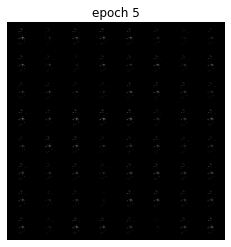

Epoch 5 of 100
Generator loss: 10.09953499, Discriminator loss: 0.13151929


118it [00:21,  5.44it/s]                         


Epoch 6 of 100
Generator loss: 11.29802227, Discriminator loss: 0.07596125


118it [00:21,  5.42it/s]                         


Epoch 7 of 100
Generator loss: 11.10197544, Discriminator loss: 0.03774739


118it [00:21,  5.46it/s]                         


Epoch 8 of 100
Generator loss: 10.41817093, Discriminator loss: 0.03702319


118it [00:21,  5.47it/s]                         


Epoch 9 of 100
Generator loss: 11.86918926, Discriminator loss: 0.04518745


118it [00:21,  5.40it/s]                         
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


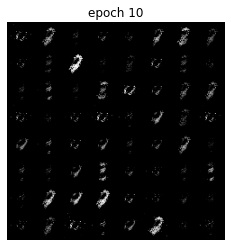

Epoch 10 of 100
Generator loss: 11.08187485, Discriminator loss: 0.07872832


118it [00:21,  5.42it/s]                         


Epoch 11 of 100
Generator loss: 11.42706203, Discriminator loss: 0.06035592


118it [00:21,  5.46it/s]                         


Epoch 12 of 100
Generator loss: 11.49709797, Discriminator loss: 0.12765402


118it [00:21,  5.45it/s]                         


Epoch 13 of 100
Generator loss: 10.31739998, Discriminator loss: 0.09776708


118it [00:21,  5.47it/s]                         


Epoch 14 of 100
Generator loss: 9.86647606, Discriminator loss: 0.13008665


118it [00:21,  5.41it/s]                         
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


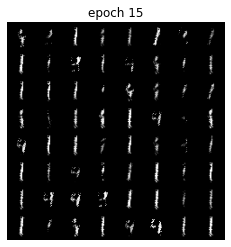

Epoch 15 of 100
Generator loss: 8.79784012, Discriminator loss: 0.18335909


118it [00:21,  5.42it/s]                         


Epoch 16 of 100
Generator loss: 8.50944424, Discriminator loss: 0.19159840


118it [00:21,  5.41it/s]                         


Epoch 17 of 100
Generator loss: 7.28819132, Discriminator loss: 0.31981599


118it [00:22,  5.35it/s]                         


Epoch 18 of 100
Generator loss: 7.39309025, Discriminator loss: 0.24120046


118it [00:22,  5.35it/s]                         


Epoch 19 of 100
Generator loss: 7.31712532, Discriminator loss: 0.24091054


118it [00:21,  5.40it/s]                         
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


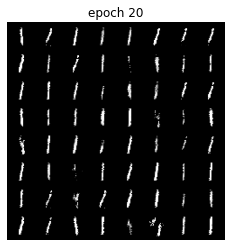

Epoch 20 of 100
Generator loss: 7.01685333, Discriminator loss: 0.31317526


118it [00:22,  5.32it/s]                         


Epoch 21 of 100
Generator loss: 6.38185072, Discriminator loss: 0.32940757


118it [00:22,  5.34it/s]                         


Epoch 22 of 100
Generator loss: 6.33239603, Discriminator loss: 0.34040537


118it [00:21,  5.37it/s]                         


Epoch 23 of 100
Generator loss: 5.93157196, Discriminator loss: 0.41130993


118it [00:22,  5.34it/s]                         


Epoch 24 of 100
Generator loss: 5.57020187, Discriminator loss: 0.49932998


118it [00:21,  5.38it/s]                         
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


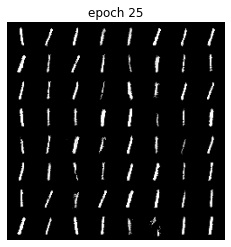

Epoch 25 of 100
Generator loss: 5.28031540, Discriminator loss: 0.56128556


118it [00:21,  5.38it/s]                         


Epoch 26 of 100
Generator loss: 4.94588518, Discriminator loss: 0.68433642


118it [00:21,  5.39it/s]                         


Epoch 27 of 100
Generator loss: 4.78311157, Discriminator loss: 0.67761350


118it [00:21,  5.42it/s]                         


Epoch 28 of 100
Generator loss: 4.52357578, Discriminator loss: 0.74979901


118it [00:21,  5.38it/s]                         


Epoch 29 of 100
Generator loss: 4.54418516, Discriminator loss: 0.77190149


118it [00:21,  5.37it/s]                         
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


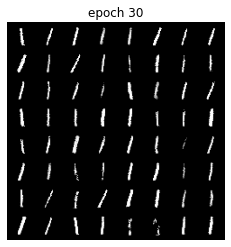

Epoch 30 of 100
Generator loss: 4.45470238, Discriminator loss: 0.80185294


118it [00:22,  5.36it/s]                         


Epoch 31 of 100
Generator loss: 4.29877615, Discriminator loss: 0.80540222


118it [00:21,  5.37it/s]                         


Epoch 32 of 100
Generator loss: 4.16591787, Discriminator loss: 0.90053397


118it [00:21,  5.38it/s]                         


Epoch 33 of 100
Generator loss: 4.05431652, Discriminator loss: 0.96817857


118it [00:21,  5.37it/s]                         


Epoch 34 of 100
Generator loss: 3.80258775, Discriminator loss: 1.03089535


118it [00:22,  5.36it/s]                         
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


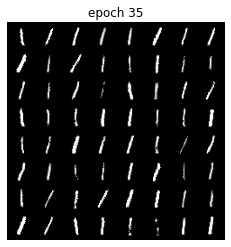

Epoch 35 of 100
Generator loss: 3.80600548, Discriminator loss: 1.02638984


118it [00:22,  5.35it/s]                         


Epoch 36 of 100
Generator loss: 3.77018666, Discriminator loss: 1.06235671


118it [00:21,  5.39it/s]                         


Epoch 37 of 100
Generator loss: 3.55836368, Discriminator loss: 1.15813911


118it [00:21,  5.42it/s]                         


Epoch 38 of 100
Generator loss: 3.46387577, Discriminator loss: 1.23016834


118it [00:21,  5.40it/s]                         


Epoch 39 of 100
Generator loss: 3.38501978, Discriminator loss: 1.23824298


118it [00:22,  5.34it/s]                         
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


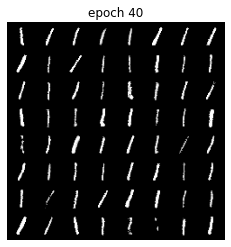

Epoch 40 of 100
Generator loss: 3.34428120, Discriminator loss: 1.26326656


118it [00:22,  5.31it/s]                         


Epoch 41 of 100
Generator loss: 3.34396362, Discriminator loss: 1.27369022


118it [00:22,  5.31it/s]                         


Epoch 42 of 100
Generator loss: 3.27820253, Discriminator loss: 1.27754009


118it [00:22,  5.34it/s]                         


Epoch 43 of 100
Generator loss: 3.28958344, Discriminator loss: 1.30453992


118it [00:22,  5.33it/s]                         


Epoch 44 of 100
Generator loss: 3.24962258, Discriminator loss: 1.32740879


118it [00:21,  5.38it/s]                         
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


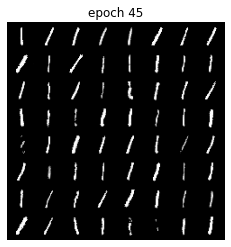

Epoch 45 of 100
Generator loss: 3.16755772, Discriminator loss: 1.37758899


118it [00:22,  5.36it/s]                         


Epoch 46 of 100
Generator loss: 3.15898609, Discriminator loss: 1.37283468


118it [00:22,  5.35it/s]                         


Epoch 47 of 100
Generator loss: 3.02750874, Discriminator loss: 1.43329942


118it [00:22,  5.29it/s]                         


Epoch 48 of 100
Generator loss: 2.98159742, Discriminator loss: 1.46445656


118it [00:22,  5.30it/s]                         


Epoch 49 of 100
Generator loss: 2.94224977, Discriminator loss: 1.48616815


118it [00:22,  5.29it/s]                         
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


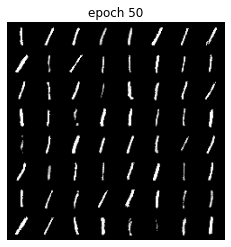

Epoch 50 of 100
Generator loss: 2.95017982, Discriminator loss: 1.48435605


118it [00:22,  5.31it/s]                         


Epoch 51 of 100
Generator loss: 2.89723825, Discriminator loss: 1.52999616


118it [00:22,  5.35it/s]                         


Epoch 52 of 100
Generator loss: 2.88299799, Discriminator loss: 1.52853465


118it [00:22,  5.27it/s]                         


Epoch 53 of 100
Generator loss: 3.00641870, Discriminator loss: 1.49911642


118it [00:22,  5.35it/s]                         


Epoch 54 of 100
Generator loss: 2.95238447, Discriminator loss: 1.51245689


118it [00:22,  5.29it/s]                         
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


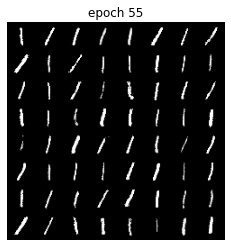

Epoch 55 of 100
Generator loss: 2.93392324, Discriminator loss: 1.52018297


118it [00:22,  5.29it/s]                         


Epoch 56 of 100
Generator loss: 2.85258174, Discriminator loss: 1.55305636


118it [00:22,  5.28it/s]                         


Epoch 57 of 100
Generator loss: 2.84521008, Discriminator loss: 1.57693028


118it [00:22,  5.35it/s]                         


Epoch 58 of 100
Generator loss: 2.87145185, Discriminator loss: 1.60030115


118it [00:22,  5.25it/s]                         


Epoch 59 of 100
Generator loss: 2.90174341, Discriminator loss: 1.56082392


118it [00:22,  5.29it/s]                         
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


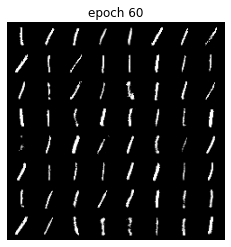

Epoch 60 of 100
Generator loss: 2.84819031, Discriminator loss: 1.59910810


118it [00:22,  5.30it/s]                         


Epoch 61 of 100
Generator loss: 2.81944227, Discriminator loss: 1.60719645


118it [00:22,  5.27it/s]                         


Epoch 62 of 100
Generator loss: 2.85558724, Discriminator loss: 1.60340285


118it [00:22,  5.30it/s]                         


Epoch 63 of 100
Generator loss: 2.82250905, Discriminator loss: 1.62164760


118it [00:22,  5.28it/s]                         


Epoch 64 of 100
Generator loss: 2.86434507, Discriminator loss: 1.61899447


118it [00:21,  5.45it/s]                         
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


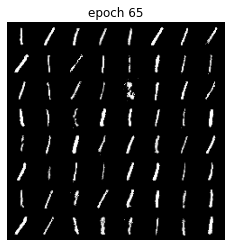

Epoch 65 of 100
Generator loss: 2.83556676, Discriminator loss: 1.61575174


118it [00:21,  5.42it/s]                         


Epoch 66 of 100
Generator loss: 2.83530354, Discriminator loss: 1.60365653


118it [00:22,  5.24it/s]                         


Epoch 67 of 100
Generator loss: 2.83802533, Discriminator loss: 1.60578167


118it [00:22,  5.21it/s]                         


Epoch 68 of 100
Generator loss: 2.79605198, Discriminator loss: 1.62080944


118it [00:22,  5.27it/s]                         


Epoch 69 of 100
Generator loss: 2.81448793, Discriminator loss: 1.62303483


118it [00:22,  5.25it/s]                         
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


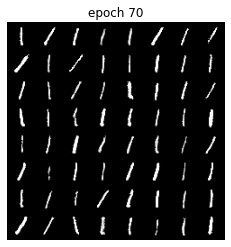

Epoch 70 of 100
Generator loss: 2.81977081, Discriminator loss: 1.63297284


118it [00:22,  5.29it/s]                         


Epoch 71 of 100
Generator loss: 2.72877145, Discriminator loss: 1.68299317


118it [00:22,  5.25it/s]                         


Epoch 72 of 100
Generator loss: 2.73116207, Discriminator loss: 1.67658031


118it [00:21,  5.51it/s]                         


Epoch 73 of 100
Generator loss: 2.73771214, Discriminator loss: 1.67696178


118it [00:21,  5.55it/s]                         


Epoch 74 of 100
Generator loss: 2.75826979, Discriminator loss: 1.64185357


118it [00:21,  5.45it/s]                         
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


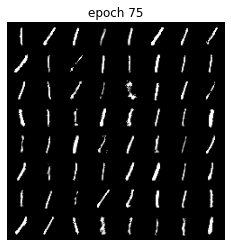

Epoch 75 of 100
Generator loss: 2.72284603, Discriminator loss: 1.69627738


118it [00:22,  5.30it/s]                         


Epoch 76 of 100
Generator loss: 2.71468806, Discriminator loss: 1.70442545


118it [00:22,  5.29it/s]                         


Epoch 77 of 100
Generator loss: 2.68070126, Discriminator loss: 1.74428093


118it [00:22,  5.30it/s]                         


Epoch 78 of 100
Generator loss: 2.65260220, Discriminator loss: 1.76301420


118it [00:22,  5.30it/s]                         


Epoch 79 of 100
Generator loss: 2.67656565, Discriminator loss: 1.74935806


118it [00:22,  5.34it/s]                         
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


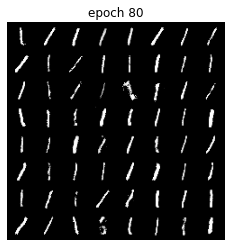

Epoch 80 of 100
Generator loss: 2.66402960, Discriminator loss: 1.77388906


118it [00:22,  5.32it/s]                         


Epoch 81 of 100
Generator loss: 2.66373801, Discriminator loss: 1.75591910


118it [00:22,  5.25it/s]                         


Epoch 82 of 100
Generator loss: 2.65163732, Discriminator loss: 1.73743165


118it [00:21,  5.42it/s]                         


Epoch 83 of 100
Generator loss: 2.75145936, Discriminator loss: 1.70835590


118it [00:21,  5.53it/s]                         


Epoch 84 of 100
Generator loss: 2.70638251, Discriminator loss: 1.70953572


118it [00:21,  5.52it/s]                         
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


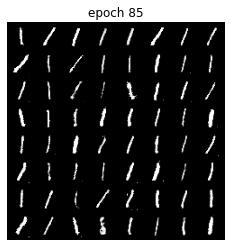

Epoch 85 of 100
Generator loss: 2.70469427, Discriminator loss: 1.72908783


118it [00:21,  5.55it/s]                         


Epoch 86 of 100
Generator loss: 2.72151804, Discriminator loss: 1.71660030


118it [00:21,  5.54it/s]                         


Epoch 87 of 100
Generator loss: 2.71432233, Discriminator loss: 1.71008575


118it [00:21,  5.54it/s]                         


Epoch 88 of 100
Generator loss: 2.70103145, Discriminator loss: 1.72030509


118it [00:21,  5.53it/s]                         


Epoch 89 of 100
Generator loss: 2.70792222, Discriminator loss: 1.72586262


118it [00:21,  5.60it/s]                         
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


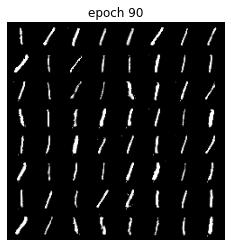

Epoch 90 of 100
Generator loss: 2.64571929, Discriminator loss: 1.74148238


118it [00:21,  5.54it/s]                         


Epoch 91 of 100
Generator loss: 2.66591334, Discriminator loss: 1.75210154


118it [00:21,  5.58it/s]                         


Epoch 92 of 100
Generator loss: 2.65636706, Discriminator loss: 1.76201010


118it [00:21,  5.58it/s]                         


Epoch 93 of 100
Generator loss: 2.67241240, Discriminator loss: 1.73843706


118it [00:20,  5.65it/s]                         


Epoch 94 of 100
Generator loss: 2.64894533, Discriminator loss: 1.76709187


118it [00:21,  5.61it/s]                         
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


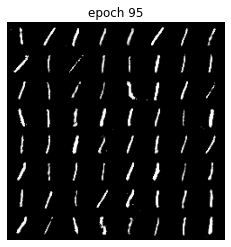

Epoch 95 of 100
Generator loss: 2.59090424, Discriminator loss: 1.78745568


118it [00:21,  5.61it/s]                         


Epoch 96 of 100
Generator loss: 2.63699651, Discriminator loss: 1.77685881


118it [00:21,  5.59it/s]                         


Epoch 97 of 100
Generator loss: 2.60335064, Discriminator loss: 1.79173601


118it [00:21,  5.60it/s]                         


Epoch 98 of 100
Generator loss: 2.59152246, Discriminator loss: 1.81644380


118it [00:21,  5.59it/s]                         


Epoch 99 of 100
Generator loss: 2.64856458, Discriminator loss: 1.80692661


118it [00:21,  5.58it/s]                         
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


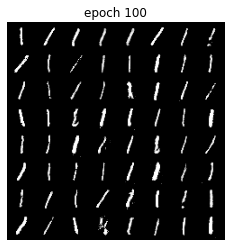

Epoch 100 of 100
Generator loss: 2.59354544, Discriminator loss: 1.81793261


In [ ]:
torch.manual_seed(7777)

def generator_loss(output, true_label):
    return criterion(output, true_label)
    
def discriminator_loss(output, true_label):
    return criterion(output, true_label)
    

for epoch in range(epochs):
    loss_g = 0.0
    loss_d = 0.0
    for bi, data in tqdm(enumerate(train_loader), total=int(len(train_data)/train_loader.batch_size)):
        real_images, _ = data
        real_images = real_images.to(device)

        # Training the discriminator for 'k' steps
        for i in range(k):
           # Creating fake samples from generator to train the discriminator
           fake_images = generator(create_noise(sample_size, nz)).detach()
           fake_labels = label_fake(fake_images.shape[0])
           
           # Creating true labels for real images from dataset
           real_labels = label_real(real_images.shape[0])
           
           optim_d.zero_grad()

           # Generating first term of the loss from discriminator and backpropagating it
           real_output = discriminator(real_images)
           real_loss = discriminator_loss(real_output, real_labels)
           
           # Generating second term of the loss from discriminator and backpropagating it
           fake_output = discriminator(fake_images)
           fake_loss = discriminator_loss(fake_output, fake_labels)

           real_loss.backward()
           fake_loss.backward()

           optim_d.step()

           # Actual discriminator loss is the sum of both terms
           loss_d += real_loss + fake_loss

        # Training the generator for one step
        fake_images = generator(create_noise(sample_size, nz))
        real_labels = label_real(fake_images.shape[0])
        fake_labels = label_fake(fake_images.shape[0])

        optim_g.zero_grad()

        # Passing fake images through discriminator
        output = discriminator(fake_images)

        # Generating the loss for the generator
        gen_loss = generator_loss(output, real_labels)

        gen_loss.backward()

        optim_g.step()

        loss_g += gen_loss
    
    
    # create the final fake image for the epoch
    generated_img = generator(noise).cpu().detach()
    
    # make the images as grid
    generated_img = make_grid(generated_img)
    
    # visualize generated images
    if (epoch + 1) % 5 == 0:
        plt.imshow(generated_img.permute(1, 2, 0))
        plt.title(f'epoch {epoch+1}')
        plt.axis('off')
        plt.show()
    
    # save the generated torch tensor models to disk
    save_generator_image(generated_img, f"outputs/gen_img{epoch+1}.png")
    images.append(generated_img)
    epoch_loss_g = loss_g / bi # total generator loss for the epoch
    epoch_loss_d = loss_d / bi # total discriminator loss for the epoch
    losses_g.append(epoch_loss_g)
    losses_d.append(epoch_loss_d)
    
    print(f"Epoch {epoch+1} of {epochs}")
    print(f"Generator loss: {epoch_loss_g:.8f}, Discriminator loss: {epoch_loss_d:.8f}")

In [ ]:
print('DONE TRAINING')
torch.save(generator.state_dict(), 'outputs/generator.pth')

DONE TRAINING


In [ ]:
# save the generated images as GIF file
imgs = [np.array(to_pil_image(img)) for img in images]
imageio.mimsave('outputs/generator_images.gif', imgs)

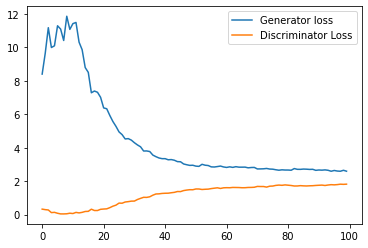

In [ ]:
# plot and save the generator and discriminator loss
plt.figure()
plt.plot(losses_g, label='Generator loss')
plt.plot(losses_d, label='Discriminator Loss')
plt.legend()
plt.savefig('outputs/loss.png')